In [15]:
!wget "http://www.vision.ee.ethz.ch/ntire18/i-haze/I-HAZE.zip"

--2021-05-18 07:46:40--  http://www.vision.ee.ethz.ch/ntire18/i-haze/I-HAZE.zip
正在查找主機 www.vision.ee.ethz.ch (www.vision.ee.ethz.ch)... 129.132.19.216, 2001:67c:10ec:254::216
正在連接 www.vision.ee.ethz.ch (www.vision.ee.ethz.ch)|129.132.19.216|:80... 連上了。
已送出 HTTP 要求，正在等候回應... 301 
位置：https://data.vision.ee.ethz.ch/cvl/ntire18//i-haze/I-HAZE.zip [跟隨至新的 URL]
--2021-05-18 07:46:42--  https://data.vision.ee.ethz.ch/cvl/ntire18//i-haze/I-HAZE.zip
正在查找主機 data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
正在連接 data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... 連上了。
已送出 HTTP 要求，正在等候回應... 200 OK
長度: 326825391 (312M) [application/zip]
Saving to: ‘I-HAZE.zip’

I-HAZE.zip          100%[===================>] 311.68M  11.8MB/s    in 28s     

2021-05-18 07:47:12 (11.0 MB/s) - ‘I-HAZE.zip’ saved [326825391/326825391]



In [1]:
import os
import cv2
import PIL
import glob
import torch
import scipy
import random
import shutil
import numpy as np
import pandas as pd
from math import exp
import torch.nn as nn
from PIL import Image as Img
from tqdm import tqdm
from scipy import ndimage
import torch.optim as optim
from sklearn import metrics
from torch.utils import data
from sklearn import datasets
from skimage.io import imsave
import matplotlib.pyplot as plt
import torch.nn.functional as F3
import torch.nn.functional as F9
from sklearn import linear_model
from skimage.feature import canny
from torch.autograd import Variable
import torchvision.models as models
from collections import OrderedDict
from torch.autograd import Variable
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt1
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from IPython.display import display, Image
from skimage.color import lab2rgb, rgb2lab
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import torchvision.transforms.functional as F6
import torchvision.transforms.functional as F7
from sklearn.preprocessing import OneHotEncoder 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from sklearn.model_selection import cross_val_score, cross_val_predict

Defining our generator (UNet)

In [2]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=3, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

        self.conv_1 = nn.Conv2d(
            in_channels=128, out_channels=out_channels, kernel_size=1
        )

        self.pyramid_3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, padding=1),
            nn.InstanceNorm2d(16, track_running_stats=False),
            nn.ReLU(True)
        )

        self.pyramid_5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=5, padding=2),
            nn.InstanceNorm2d(16, track_running_stats=False),
            nn.ReLU(True)
        )

        self.pyramid_7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=7, padding=3),
            nn.InstanceNorm2d(16, track_running_stats=False),
            nn.ReLU(True)
        )

        self.pyramid_11 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=11, padding=5),
            nn.InstanceNorm2d(16, track_running_stats=False),
            nn.ReLU(True)
        )

        self.pyramid_17 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=17, padding=8),
            nn.InstanceNorm2d(16, track_running_stats=False),
            nn.ReLU(True)
        )

        self.pyramid_25 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=25, padding=12),
            nn.InstanceNorm2d(16, track_running_stats=False),
            nn.ReLU(True)
        )

        self.pyramid_35 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=35, padding=17),
            nn.InstanceNorm2d(16, track_running_stats=False),
            nn.ReLU(True)
        )

        self.pyramid_45 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=45, padding=22),
            nn.InstanceNorm2d(16, track_running_stats=False),
            nn.ReLU(True)
        )

    def forward(self, x):

        #block1
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        coonv1_1 = self.conv(dec1)

        
        #block2 
        enc1_2 = self.encoder1(coonv1_1)
        enc2_2 = self.encoder2(self.pool1(enc1_2))
        enc3_2 = self.encoder3(self.pool2(enc2_2))
        enc4_2 = self.encoder4(self.pool3(enc3_2))

        bottleneck_2 = self.bottleneck(self.pool4(enc4_2))

        dec4_2 = self.upconv4(bottleneck_2)
        dec4_2 = torch.cat((dec4_2, enc4_2), dim=1)
        dec4_2 = self.decoder4(dec4_2)
        dec3_2 = self.upconv3(dec4_2)
        dec3_2 = torch.cat((dec3_2, enc3_2), dim=1)
        dec3_2 = self.decoder3(dec3_2)
        dec2_2 = self.upconv2(dec3_2)
        dec2_2 = torch.cat((dec2_2, enc2_2), dim=1)
        dec2_2 = self.decoder2(dec2_2)
        dec1_2 = self.upconv1(dec2_2)
        dec1_2 = torch.cat((dec1_2, enc1_2), dim=1)
        dec1_2 = self.decoder1(dec1_2)
        coonv1_2 = self.conv(dec1_2)


        
        #block3
        enc1_3 = self.encoder1(coonv1_2)
        enc2_3 = self.encoder2(self.pool1(enc1_3))
        enc3_3 = self.encoder3(self.pool2(enc2_3))
        enc4_3 = self.encoder4(self.pool3(enc3_3))

        bottleneck_3 = self.bottleneck(self.pool4(enc4_3))

        dec4_3 = self.upconv4(bottleneck_3)
        dec4_3 = torch.cat((dec4_3, enc4_3), dim=1)
        dec4_3 = self.decoder4(dec4_3)
        dec3_3 = self.upconv3(dec4_3)
        dec3_3 = torch.cat((dec3_3, enc3_3), dim=1)
        dec3_3 = self.decoder3(dec3_3)
        dec2_3 = self.upconv2(dec3_3)
        dec2_3 = torch.cat((dec2_3, enc2_3), dim=1)
        dec2_3 = self.decoder2(dec2_3)
        dec1_3 = self.upconv1(dec2_3)
        dec1_3 = torch.cat((dec1_3, enc1_3), dim=1)
        dec1_3 = self.decoder1(dec1_3)
        coonv1_3 = self.conv(dec1_3)


        #block4
        enc1_4 = self.encoder1(coonv1_3)
        enc2_4 = self.encoder2(self.pool1(enc1_4))
        enc3_4 = self.encoder3(self.pool2(enc2_4))
        enc4_4 = self.encoder4(self.pool3(enc3_4))

        bottleneck_4 = self.bottleneck(self.pool4(enc4_4))

        dec4_4 = self.upconv4(bottleneck_4)
        dec4_4 = torch.cat((dec4_4, enc4_4), dim=1)
        dec4_4 = self.decoder4(dec4_4)
        dec3_4 = self.upconv3(dec4_4)
        dec3_4 = torch.cat((dec3_4, enc3_4), dim=1)
        dec3_4 = self.decoder3(dec3_4)
        dec2_4 = self.upconv2(dec3_4)
        dec2_4 = torch.cat((dec2_4, enc2_4), dim=1)
        dec2_4 = self.decoder2(dec2_4)
        dec1_4 = self.upconv1(dec2_4)
        dec1_4 = torch.cat((dec1_4, enc1_4), dim=1)
        dec1_4 = self.decoder1(dec1_4)
        coonv1_4 = self.conv(dec1_4)

        #concatenation of different UNet feature maps
        concat = torch.cat((coonv1_1, coonv1_2, coonv1_3, coonv1_4  ), dim=1)


        #pyramid convolution
        conv_pyramid_3 =  self.pyramid_3(concat)
        conv_pyramid_5 =  self.pyramid_5(concat)
        conv_pyramid_7 =  self.pyramid_7(concat)
        conv_pyramid_11 =  self.pyramid_11(concat)
        conv_pyramid_17 =  self.pyramid_17(concat)
        conv_pyramid_25 =  self.pyramid_25(concat)
        conv_pyramid_35 =  self.pyramid_35(concat)
        conv_pyramid_45 =  self.pyramid_45(concat)

        #concatenation of feature maps corresponding different convolution filters present in Pyramid convolution layer
        concat_py = torch.cat(( conv_pyramid_3, conv_pyramid_5, conv_pyramid_7, conv_pyramid_11, conv_pyramid_17, conv_pyramid_25, conv_pyramid_35, conv_pyramid_45), dim=1)
      
        return torch.sigmoid(self.conv_1(concat_py))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=False)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=False)),
                ]
            )
        )

Defining our Discriminator

In [3]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, use_sigmoid=True, use_spectral_norm=True):
        super().__init__()
        self.use_sigmoid = use_sigmoid

        self.conv1 = self.features = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=4, stride=2, padding=1, bias=not use_spectral_norm), use_spectral_norm),
            nn.LeakyReLU(0.2, inplace=False),
        )

        self.conv2 = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=not use_spectral_norm), use_spectral_norm),
            nn.LeakyReLU(0.2, inplace=False),
        )

        self.conv3 = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=not use_spectral_norm), use_spectral_norm),
            nn.LeakyReLU(0.2, inplace=False),
        )

        self.conv4 = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1, bias=not use_spectral_norm), use_spectral_norm),
            nn.LeakyReLU(0.2, inplace=False),
        )

        self.conv5 = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, bias=not use_spectral_norm), use_spectral_norm),
        )


    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        outputs = conv5
        if self.use_sigmoid:
            outputs = torch.sigmoid(conv5)

        return outputs, [conv1, conv2, conv3, conv4, conv5]

def spectral_norm(module, mode=True):
    if mode:
        return nn.utils.spectral_norm(module)

    return module

Defining our loss functions

In [4]:
class AdversarialLoss(nn.Module):
    r"""
    Adversarial loss
    https://arxiv.org/abs/1711.10337
    """

    def __init__(self, type='hinge', target_real_label=1.0, target_fake_label=0.0):
        r"""
        type = nsgan | lsgan | hinge
        """
        super().__init__()

        self.type = type
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))

        if type == 'nsgan':
            self.criterion = nn.BCELoss()

        elif type == 'lsgan':
            self.criterion = nn.MSELoss()

        elif type == 'hinge':
            self.criterion = nn.ReLU()

    def __call__(self, outputs, is_real, is_disc=None):
        if self.type == 'hinge':
            if is_real:
              return -torch.log(outputs).mean()
            else:
              return -torch.log(1-outputs).mean()


        else:
            labels = (self.real_label if is_real else self.fake_label).expand_as(outputs)
            loss = self.criterion(outputs, labels)
            return loss



class ContentLoss(nn.Module):
    r"""
    Perceptual loss, VGG-based
    https://arxiv.org/abs/1603.08155
    https://github.com/dxyang/StyleTransfer/blob/master/utils.py
    """

    def __init__(self, weights=[1.0, 1.0, 1.0, 1.0, 1.0]):
        super().__init__()
        self.add_module('vgg', VGG19().cuda())
        self.criterion = torch.nn.L1Loss().cuda()
        self.weights = weights

    def __call__(self, x, y):
        # Compute features
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)

        content_loss = 0.0
        content_loss += self.weights[0] * self.criterion(x_vgg['relu1_1'], y_vgg['relu1_1'])
        content_loss += self.weights[1] * self.criterion(x_vgg['relu2_1'], y_vgg['relu2_1'])
        content_loss += self.weights[2] * self.criterion(x_vgg['relu3_1'], y_vgg['relu3_1'])
        content_loss += self.weights[3] * self.criterion(x_vgg['relu4_1'], y_vgg['relu4_1'])
        content_loss += self.weights[4] * self.criterion(x_vgg['relu5_1'], y_vgg['relu5_1'])


        return content_loss



class VGG19(torch.nn.Module):
    def __init__(self):
        super().__init__()
        features = models.vgg19(pretrained=True).features
        self.relu1_1 = torch.nn.Sequential()
        self.relu1_2 = torch.nn.Sequential()

        self.relu2_1 = torch.nn.Sequential()
        self.relu2_2 = torch.nn.Sequential()

        self.relu3_1 = torch.nn.Sequential()
        self.relu3_2 = torch.nn.Sequential()
        self.relu3_3 = torch.nn.Sequential()
        self.relu3_4 = torch.nn.Sequential()

        self.relu4_1 = torch.nn.Sequential()
        self.relu4_2 = torch.nn.Sequential()
        self.relu4_3 = torch.nn.Sequential()
        self.relu4_4 = torch.nn.Sequential()

        self.relu5_1 = torch.nn.Sequential()
        self.relu5_2 = torch.nn.Sequential()
        self.relu5_3 = torch.nn.Sequential()
        self.relu5_4 = torch.nn.Sequential()

        for x in range(2):
            self.relu1_1.add_module(str(x), features[x])

        for x in range(2, 4):
            self.relu1_2.add_module(str(x), features[x])

        for x in range(4, 7):
            self.relu2_1.add_module(str(x), features[x])

        for x in range(7, 9):
            self.relu2_2.add_module(str(x), features[x])

        for x in range(9, 12):
            self.relu3_1.add_module(str(x), features[x])

        for x in range(12, 14):
            self.relu3_2.add_module(str(x), features[x])

        for x in range(14, 16):
            self.relu3_3.add_module(str(x), features[x])

        for x in range(16, 18):
            self.relu3_4.add_module(str(x), features[x])

        for x in range(18, 21):
            self.relu4_1.add_module(str(x), features[x])

        for x in range(21, 23):
            self.relu4_2.add_module(str(x), features[x])

        for x in range(23, 25):
            self.relu4_3.add_module(str(x), features[x])

        for x in range(25, 27):
            self.relu4_4.add_module(str(x), features[x])

        for x in range(27, 30):
            self.relu5_1.add_module(str(x), features[x])

        for x in range(30, 32):
            self.relu5_2.add_module(str(x), features[x])

        for x in range(32, 34):
            self.relu5_3.add_module(str(x), features[x])

        for x in range(34, 36):
            self.relu5_4.add_module(str(x), features[x])

        # don't need the gradients, just want the features
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        relu1_1 = self.relu1_1(x)
        relu1_2 = self.relu1_2(relu1_1)

        relu2_1 = self.relu2_1(relu1_2)
        relu2_2 = self.relu2_2(relu2_1)

        relu3_1 = self.relu3_1(relu2_2)
        relu3_2 = self.relu3_2(relu3_1)
        relu3_3 = self.relu3_3(relu3_2)
        relu3_4 = self.relu3_4(relu3_3)

        relu4_1 = self.relu4_1(relu3_4)
        relu4_2 = self.relu4_2(relu4_1)
        relu4_3 = self.relu4_3(relu4_2)
        relu4_4 = self.relu4_4(relu4_3)

        relu5_1 = self.relu5_1(relu4_4)
        relu5_2 = self.relu5_2(relu5_1)
        relu5_3 = self.relu5_3(relu5_2)
        relu5_4 = self.relu5_4(relu5_3)

        out = {
            'relu1_1': relu1_1,
            'relu1_2': relu1_2,

            'relu2_1': relu2_1,
            'relu2_2': relu2_2,

            'relu3_1': relu3_1,
            'relu3_2': relu3_2,
            'relu3_3': relu3_3,
            'relu3_4': relu3_4,

            'relu4_1': relu4_1,
            'relu4_2': relu4_2,
            'relu4_3': relu4_3,
            'relu4_4': relu4_4,

            'relu5_1': relu5_1,
            'relu5_2': relu5_2,
            'relu5_3': relu5_3,
            'relu5_4': relu5_4,
        }
        return out

In [5]:
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F3.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F3.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F3.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F3.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F3.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

Defining our model i.e. DU_Net

In [6]:
class DU_Net(nn.Module):

    def __init__(self, unet_input, unet_output, discriminator_input):
        super().__init__()


        unet = UNet(in_channels=unet_input ,out_channels=unet_output)
        unet = unet.cuda()

        discriminator = Discriminator(in_channels=discriminator_input , use_sigmoid=True)
        discriminator = discriminator.cuda()

        criterion = nn.MSELoss()
        adversarial_loss = AdversarialLoss(type='hinge')
        l1_loss = nn.L1Loss()
        content_loss = ContentLoss()
        ssim = SSIM(window_size = 11)
        bce = nn.BCELoss()

        self.add_module('unet', unet)
        self.add_module('discriminator', discriminator)

        self.add_module('criterion', criterion)
        self.add_module('adversarial_loss', adversarial_loss)
        self.add_module('l1_loss', l1_loss)
        self.add_module('content_loss', content_loss)
        self.add_module('ssim_loss', ssim)
        self.add_module('bce_loss', bce)
        

        self.unet_optimizer = optim.Adam(
            unet.parameters(), 
            lr = float(0.001),
            betas=(0.9, 0.999)
            )

        self.dis_optimizer = optim.Adam(
             params=discriminator.parameters(),
             lr=float(0.001),
             betas=(0.9, 0.999)
             )

        self.unet_input = unet_input
        self.unet_output = unet_output
        self.discriminator_input = discriminator_input


    def load(self, path_unet, path_discriminator):
        weight_unet = torch.load(path_unet)
        weight_discriminator = torch.load(path_discriminator)
        self.unet.load_state_dict(weight_unet)
        self.discriminator.load_state_dict(weight_discriminator)

    def save_weight(self, path_unet, path_dis):
        torch.save(self.unet.state_dict(), path_unet)
        torch.save(self.discriminator.state_dict(), path_dis)

    def process(self, haze_images, dehaze_images):

        # zero optimizers
        self.unet_optimizer.zero_grad()
        self.dis_optimizer.zero_grad()


        # find output and initialize loss to zero
        unet_loss = 0
        dis_loss = 0

        outputs = self.unet(haze_images.cuda())


        # discriminator loss
        dis_real, dis_real_feat = self.discriminator(dehaze_images.cuda())        
        dis_fake, dis_fake_feat = self.discriminator(outputs.detach().cuda())       
        dis_real_loss = self.adversarial_loss(dis_real, True, True)
        dis_fake_loss = self.adversarial_loss(dis_fake, False, True)
        dis_loss += dis_real_loss + dis_fake_loss


        # unet loss
        unet_fake, unet_fake_feat = self.discriminator(outputs.cuda())        
        unet_gan_loss = self.adversarial_loss(unet_fake, True, False) * 0.7
        unet_loss += unet_gan_loss

        unet_criterion = self.criterion(outputs.cuda(), dehaze_images.cuda())
        unet_loss += unet_criterion




        gen_content_loss = self.content_loss(outputs.cuda(), dehaze_images.cuda())
        gen_content_loss = (gen_content_loss * 0.5).cuda()
        unet_loss += gen_content_loss.cuda()
        
        
        ssim_loss =  self.ssim_loss(outputs.cuda(), dehaze_images.cuda())
        ssim_loss = 1-ssim_loss
        unet_loss += ssim_loss.cuda()

        return unet_loss, dis_loss, unet_criterion, 1-ssim_loss

    def backward(self, unet_loss, dis_loss):
        dis_loss.backward(retain_graph = True)
        self.dis_optimizer.step()

        unet_loss.backward()
        self.unet_optimizer.step()
        

    def predict(self, haze_images):
      predict_mask = self.unet(haze_images.cuda())
      return predict_mask

Defining our and creating the data loader

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, haze_list, dehaze_list, augment=False):
        super().__init__()
        self.augment = augment
        self.haze_list = haze_list
        self.dehaze_list = dehaze_list
        
    def __len__(self):
        return 210

    def __getitem__(self, index):
        try:
            item = self.load_item(index)
        except:
            print('loading error: ' + self.haze_list[index])
            item = self.load_item(0)
            

        return item


    def load_item(self, index):
        val = 1024           #crop size i.e hight and width
        size_data = 25         #depends on the no. of training images in the dataset
        height_data = 4657     #heigth of the training images
        width_data = 2833      #width of the training images

        numx = random.randint(0, height_data-val)
        numy = random.randint(0, width_data-val)

        haze_image = cv2.imread(self.haze_list[index%size_data])
        dehaze_image = cv2.imread(self.dehaze_list[index%size_data])
        haze_image = Img.fromarray(haze_image)
        dehaze_image = Img.fromarray(dehaze_image)

        haze_crop=haze_image.crop((numx, numy, numx+val, numy+val))
        dehaze_crop=dehaze_image.crop((numx, numy, numx+val, numy+val))
 
        haze_crop = haze_crop.resize((512,512), resample=PIL.Image.BICUBIC)
        dehaze_crop = dehaze_crop.resize((512,512), resample=PIL.Image.BICUBIC)

        haze_crop = np.array(haze_crop)
        dehaze_crop = np.array(dehaze_crop)
        haze_crop = cv2.cvtColor(haze_crop, cv2.COLOR_BGR2YCrCb)
        dehaze_crop = cv2.cvtColor(dehaze_crop, cv2.COLOR_BGR2YCrCb)
        haze_crop = self.to_tensor(haze_crop).cuda()
        dehaze_crop = self.to_tensor(dehaze_crop).cuda()
        
        return haze_crop.cuda(), dehaze_crop.cuda()
    
    def to_tensor(self, img):
        img_t = F.to_tensor(img).float()
        return img_t


    def create_iterator(self, batch_size):
        while True:
            sample_loader = DataLoader(
                dataset=self,
                batch_size=batch_size,
                drop_last=True
            )

            for item in sample_loader:
                yield item


path_of_train_hazy_images = 'train/haze/*.jpg'
path_of_train_gt_images = 'train/gt/*.jpg'

images_paths_train_gt=glob.glob(path_of_train_gt_images)
image_paths_train_hazy=glob.glob(path_of_train_hazy_images)

train_dataset = Dataset(image_paths_train_hazy, images_paths_train_gt, augment=False)

train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=2,
            num_workers=0,
            drop_last=True,
            shuffle=False
        )

Creating the model

In [7]:
graph_gloss = []
graph_gloss_unet = []
input_unet_channel = 3
output_unet_channel = 3
input_dis_channel = 3
max_epochs = 100
DUNet = DU_Net(input_unet_channel ,output_unet_channel ,input_dis_channel).cuda()

Training function

In [9]:
path_of_test_hazy_images = 'test/haze/*.jpg'
path_for_resultant_dehaze_images = 'test/result/'
image_paths_test_hazy=glob.glob(path_of_test_hazy_images)

def to_tensor(img):
    img_t = F6.to_tensor(img).float()
    return img_t

def postprocess(img):
    img = img * 255.0
    img = img.permute(0, 2, 3, 1)
    return img.int()

In [10]:
import matplotlib.pyplot as plt

max_loss = 100

def train(max_epochs):
    for epoch in range(max_epochs):
        i=1
        mse_epoch = 0.0
        ssim_epoch = 0.0
        unet_epoch = 0.0
        for haze_images, dehaze_images, in train_loader:
            unet_loss, dis_loss, mse, ssim = DUNet.process(haze_images.cuda(), dehaze_images.cuda())
            DUNet.backward(unet_loss.cuda(), dis_loss.cuda())
            print('Epoch: '+str(epoch+1)+ ' || Batch: '+str(i)+ " || unet loss: "+str(unet_loss.cpu().item()) + " || dis loss: "+str(dis_loss.cpu().item()) + " || mse: "+str(mse.cpu().item()) + " | ssim:" + str(ssim.cpu().item()) )
            mse_epoch =  mse_epoch + mse.cpu().item() 
            ssim_epoch = ssim_epoch + ssim.cpu().item()
            unet_epoch = unet_epoch + unet_loss.cpu().item()
            i=i+1
            
        for j in range(len(image_paths_test_hazy)):
            haze_image = cv2.imread(image_paths_test_hazy[j])
            haze_image = Img.fromarray(haze_image)
            haze_image = haze_image.resize((512,512), resample=PIL.Image.BICUBIC)
            haze_image = np.array(haze_image)
            haze_image = cv2.cvtColor(haze_image, cv2.COLOR_BGR2YCrCb)
            haze_image = to_tensor(haze_image).cuda()
            haze_image = haze_image.reshape(1,3,512,512)
            dehaze_image = DUNet.predict(haze_image)
            dehaze_image = postprocess(dehaze_image)[0]
            dehaze_image = dehaze_image.cpu().detach().numpy()
            dehaze_image = dehaze_image.astype('uint8')
            dehaze_image = dehaze_image.reshape(512,512,3)
            dehaze_image = cv2.cvtColor(dehaze_image, cv2.COLOR_YCrCb2BGR)
            cv2.imwrite(path_for_resultant_dehaze_images + str(epoch) + '_' + str(i)+'.jpg', dehaze_image)
            
        print()
        mse_epoch = mse_epoch/i
        ssim_epoch = ssim_epoch/i
        unet_epoch = unet_epoch/i
        graph_gloss.append(ssim_epoch)
        graph_gloss_unet.append(unet_epoch)
        print("mse: + "+str(mse_epoch) + " | ssim: "+ str(ssim_epoch)+ " | unet:"+str(unet_epoch))
        print()
        if max_loss > unet_epoch:
            path_of_generator_weight = 'weight/self/indoor/generator.pth'  #path for storing the weights of genertaor
            path_of_discriminator_weight = 'weight/self/indoor/discriminator.pth'  #path for storing the weights of discriminator
            DUNet.save_weight(path_of_generator_weight,path_of_discriminator_weight)
            maxloss = unet_epoch

Calling training function

In [ ]:
epochs = 200
train(epochs) 

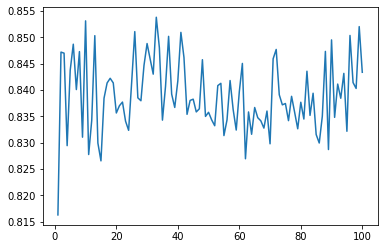

In [14]:
xlist = list(range(1,101)) 
plt.plot(xlist,graph_gloss)
plt.show()

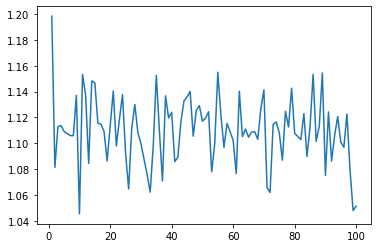

In [15]:
plt.plot(xlist,graph_gloss_unet)
plt.show()

Saving weights

In [13]:
path_of_generator_weight = 'weight/self/indoor/generator.pth'  #path for storing the weights of genertaor
path_of_discriminator_weight = 'weight/self/indoor/discriminator.pth'  #path for storing the weights of discriminator
DUNet.save_weight(path_of_generator_weight,path_of_discriminator_weight)

Saving weights

In [9]:
path_of_generator_weight = 'weight/self/indoor/generator.pth'  #path where the weights of genertaor are stored
path_of_discriminator_weight = 'weight/self/indoor/discriminator.pth'  #path where the weights of discriminator are stored
DUNet.load(path_of_generator_weight,path_of_discriminator_weight)

Runing the model on test data

In [8]:
# original saved file with DataParallel
state_dict = torch.load('weight/pre/indoor/generator.pth')
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
DUNet.unet.load_state_dict(new_state_dict)

<All keys matched successfully>

In [9]:
state_dict = torch.load('weight/pre/indoor/discriminator.pth')
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
DUNet.discriminator.load_state_dict(new_state_dict)

<All keys matched successfully>

In [10]:
def to_tensor(img):
    img_t = F6.to_tensor(img).float()
    return img_t

def postprocess(img):
        img = img * 255.0
        img = img.permute(0, 2, 3, 1)
        return img.int()

In [14]:
path_of_test_hazy_images = 'test/haze/*.jpg'
path_for_resultant_dehaze_images = 'test/result/'
image_paths_test_hazy=glob.glob(path_of_test_hazy_images)

for i in range(len(image_paths_test_hazy)):
    haze_image = cv2.imread(image_paths_test_hazy[i])
    haze_image = Img.fromarray(haze_image)
    haze_image = haze_image.resize((512,512), resample=PIL.Image.BICUBIC)
    haze_image = np.array(haze_image)
    haze_image = cv2.cvtColor(haze_image, cv2.COLOR_BGR2YCrCb)
    haze_image = to_tensor(haze_image).cuda()
    haze_image = haze_image.reshape(1,3,512,512)

    dehaze_image = DUNet.predict(haze_image) 
    
    dehaze_image = postprocess(dehaze_image)[0]
    dehaze_image = dehaze_image.cpu().detach().numpy()
    dehaze_image = dehaze_image.astype('uint8')
    dehaze_image = dehaze_image.reshape(512,512,3)
    dehaze_image = cv2.cvtColor(dehaze_image, cv2.COLOR_YCrCb2BGR)
    cv2.imwrite(path_for_resultant_dehaze_images+str(i+50)+'.jpg', dehaze_image)

Calculating the metrices i.e PSNR and SSIM for testing data

In [12]:
class EdgeAccuracy(nn.Module):
    """
    Measures the accuracy of the edge map
    """
    def __init__(self, threshold=0.5):
        super().__init__()
        self.threshold = threshold

    def __call__(self, inputs, outputs):
        labels = (inputs > self.threshold)
        outputs = (outputs > self.threshold)

        relevant = torch.sum(labels.float())
        selected = torch.sum(outputs.float())

        if relevant == 0 and selected == 0:
            return 1, 1

        true_positive = ((outputs == labels) * labels).float()
        recall = torch.sum(true_positive) / (relevant + 1e-8)
        precision = torch.sum(true_positive) / (selected + 1e-8)

        return precision, recall


class PSNR(nn.Module):
    def __init__(self, max_val=0):
        super().__init__()

        base10 = torch.log(torch.tensor(10.0))
        max_val = torch.tensor(max_val).float()

        self.register_buffer('base10', base10)
        self.register_buffer('max_val', 20 * torch.log(max_val) / base10)

    def __call__(self, a, b):
        mse = torch.mean((a.float() - b.float()) ** 2)
    
        if mse == 0:
            return 0

        return 1.0 / mse

In [13]:
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F9.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F9.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F9.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F9.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F9.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

In [15]:
ssim = SSIM(window_size = 11)
psnr = PSNR()
psnr_val = 0
psnr_val = 0.0
final_ssim = 0
final_psnr = 0

path_of_test_hazy_images = 'test/haze/*.jpg'
path_of_test_gt_images = 'test/gt/*.jpg'
path_for_resultant_dehaze_images = 'test/result/'

image_paths_test_hazy=glob.glob(path_of_test_hazy_images)
image_paths_GT=glob.glob(path_of_test_gt_images)

for i in range(len(image_paths_test_hazy)):
    im1 = cv2.imread(image_paths_GT[i])
    im1 = Img.fromarray(im1)
    im1 = im1.resize((512,512), resample=PIL.Image.BICUBIC)
    im1 = np.array(im1)
    im2 = cv2.imread('test/result/' + str(i+50)+'.jpg')

    im1 = to_tensor(im1).reshape(1,3,512,512)
    im2 = to_tensor(im2).reshape(1,3,512,512)
    
    psnr_val = psnr(im1, im2)
    final_psnr = final_psnr + 10*np.log10((psnr_val))
    final_ssim = final_ssim + ssim(im1, im2)


print(final_ssim/5.0, final_psnr/5.0)


tensor(0.8699) tensor(22.0610)
